## <center> **Анализ результатов A/B-тестирования**
____

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

c:\Users\Dmitriy Chuprinko\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dmitriy Chuprinko\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Dmitriy Chuprinko\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## <center> 1. Анализ структуры данных и их предобработка

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Начнем с исследования структуры наших данных. Выведем информацию о типах данных и количестве непустых значений.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Приведём столбец *date* к типу данных `datetime`. Убедимся в равной длительности проведения тестирования для каждой из групп. Для этого сгруппируем данные по признаку группы и определим первую и последнюю дату наблюдения для каждой из групп. Посмотрим в какой промежуток времени проводился **A/B-тест**.

In [4]:
# Приводим стобец с датой к типу данных datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Отображаем минимальное и максимальное значение в дате, чтобы узнать начало и конец тестирования
display(data.groupby(['group'])['date'].agg(['min', 'max']))

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


Посмотрим:
* Чему равно количество посещений сайта в группах А и B.

* Чему равно суммарное количество покупок в группах А и B.

* Чему равна сумма всех покупок в группах А и B.

In [5]:
data.groupby(['group']).agg({'user_id' : 'count', 'purchase' : 'sum', 'price' : 'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


Проверим, есть ли пользователи, которые в процессе **A/B-теста** попали в обе тестовые группы. Выведем уникальное число таких пользователей. Для этого создадим множество пользователей *группы А* и множество пользователей *группы B*. Пересечём два этих множества (операция `intersection`) и вычислим количество элементов в полученном множестве.


In [6]:
# Создаём множества с id пользователями
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])

# Ищем пересечения
user_intersection = set_a.intersection(set_b)

# Длинна получившегося множества
print(len(user_intersection))

1895


Исключим пользователей, оказавшихся в обеих группах.  
Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей.  
Далее мы будем работать только с очищенными от пересечений данными.

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

`user_intersection` - множество пересечений пользователей *групп А и B*.

## <center> 2. Первичный анализ результатов A/B-тестирования

Для первичного анализа результатов **A/B-тестирования** нам понадобится таблица следующего вида:

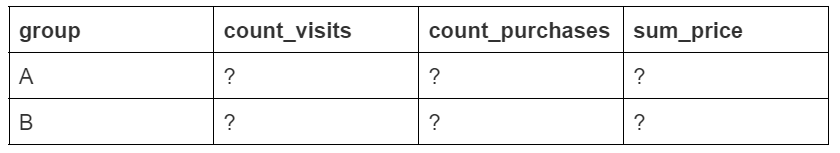
 
 
Для того, чтобы получить такую таблицу, сгруппируем данные по признаку группы. В каждой группе рассчитаем следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуем столбцы на *count_visits*, *count_purchases* и *sum_price*.

Для переименования столбцов можно использовать метод `rename()` с параметром `columns`, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.

Посмотрим чему на этот раз равно количество посещений сайта в *группах А и B*.

In [8]:
# Группируем и переименовываем данные по группам, отражая количество посещений, количество продаж и общую сумму.
group_data = updated_data.groupby(['group']).agg(
    {'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'}
).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

display(group_data)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведём **промежуточные выводы** по построенной таблице. Ответим на следующие вопросы: сопоставимо ли количество посещений обоих вариантов посадочной странице? Можно ли говорить о сбалансированности выборок?

После **исключения** пользователей оказавшихся в обеих группах разница в количестве посещений немного <u>увеличилась</u>. Поскольку эта разница совсем мала и менее 10%, что видно "невооруженным" взглядом, можно считать, что наши выборки <u>сбалансированы</u>.
____

Добавим в сгруппированную таблицу столбцы *conversion* - **конверсия** покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и *mean_check* - **средний чек** (отношение суммы покупок к количеству покупок в каждой группе). Посмотрим чему равны эти метрики в группах.

In [ ]:
# Добавляем признаки с конверсией и средним чеком
group_data['conversion'] = group_data['count_purchases'] / group_data['count_visits']*100
group_data['mean_check'] = group_data['sum_price'] / group_data['count_purchases']

print(round(group_data['conversion'], 2))
print(round(group_data['mean_check']))

group
A    12.03
B    11.89
Name: conversion, dtype: float64
group
A    81076.0
B    88665.0
Name: mean_check, dtype: float64


Сделаем **промежуточные выводы** по таблице о эффективности показателях в группах.  
После добавления новых признаков становится наглядно видно, что **конверсия** *группы А* незначительно <u>выше</u> *группы В*, но **средний чек** контрольной группы немного <u>уступает</u> тестовой. Количество посещений *группы В* хоть и чуть <u>выше</u> *группы А*, колличество продаж <u>ниже</u>.

## <center> 3. Анализ данных на предмет стабилизации метрик

Теперь давайте сравним варианты по покупательской способности туров. Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)
pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируем полученную сводную таблицу с помощью **тепловой карты** с аннотацией для наглядности.

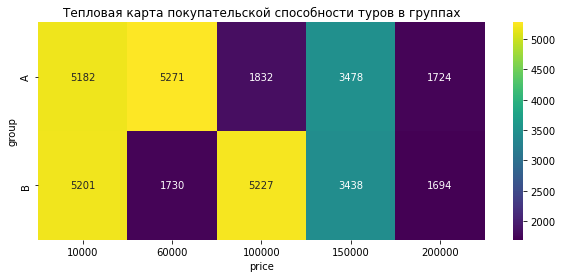

In [11]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах');

**Вывод** по графику: существенное отличие в покупательской способности между группами по турам в *Турцию* и *Таиланд*. В *группе А* <u>высокий</u> спрос на *Турцию*, а в *группе В* на *Таиланд*. По остальным турам показатели очень <u>схожие</u>.
____

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения **A/B-тестирования**.

Сгруппируем данные по дате и группе тестирования. В каждой группе вычислим количество посещений страницы, количество покупок и сумму покупок. 

Добавим в таблицу информацию о ежедневной **конверсии** (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном **среднем чеке** (ежедневная сумма покупок / ежедневное количество покупок).

In [12]:
# Группируем данные по группам и дате
daily_data = updated_data.groupby(['date', 'group'], as_index=False).agg(
    {'user_id' : 'count',
    'purchase' : 'sum',
    'price' : 'sum'}
).rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})

# Добавляем признаки с конверсией и средним чеком
daily_data['conversion'] = daily_data['count_purchases'] / daily_data['count_visits']*100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

2    11.34
3    11.39
Name: conversion, dtype: float64
2    82888.0
3    87480.0
Name: mean_check, dtype: float64


Добавим в таблицу с ежедневными показателями **кумулятивные признаки**:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

При расчете кумулятивной суммы сгруппируем данные по группам.

Вычислим кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей.

In [13]:
# Вычисляем кумулятивную сумму по посещениям, продажам и цене, сгруппировав данные по группам
daily_data['cum_cnt_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_cnt_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()

# Вычисляем кумулятивную конверсию и средний чек на основе полученных кумулятивных показателей
daily_data['cum_conv'] = daily_data['cum_cnt_purchases'] / daily_data['cum_cnt_visits']*100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_cnt_purchases']

36    11.98
37    11.90
Name: cum_conv, dtype: float64
20    81492.0
21    88352.0
Name: cum_mean_check, dtype: float64


Построим **кумулятивные** графики **конверсии** и **среднего чека** в каждой группе по дням и попробуем сделать некоторые выводы, отвечая на вопросы: можно ли назвать **A/B-тест** завершенным - стабилизировались ли значения метрик во времени? Как соотносятся **кумулятивные показатели** в каждой группе?

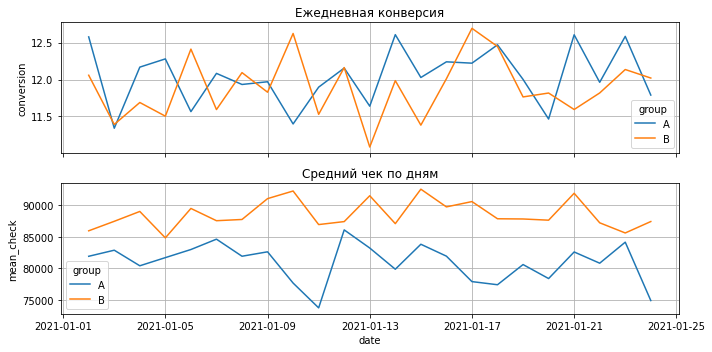

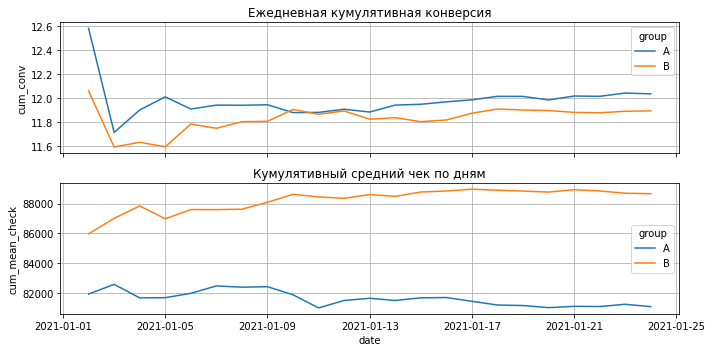

In [14]:
# Построим линейные графики ежедневных конферсии и среднего чека для последующего сравнения с кумулятивной метриками
# Создаём 2 графика
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Линейные графики ежедневных конферсии и среднего чека
sns.lineplot(data=daily_data, x='date', y='conversion', hue='group', ax=ax[0])
sns.lineplot(data=daily_data, x='date', y='mean_check', hue='group', ax=ax[1])

# Добавляем атрибуты на графики
ax[0].set_title('Ежедневная конверсия')
ax[0].grid()
ax[1].set_title('Средний чек по дням')
ax[1].grid()

# Разводим графики друг от друга
fig.tight_layout()


# Линейные графики с кумулятивными метриками конверсии и среднего чека
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

sns.lineplot(data=daily_data, x='date', y='cum_conv', hue='group', ax=ax[0])
sns.lineplot(data=daily_data, x='date', y='cum_mean_check', hue='group', ax=ax[1])

# Добавляем атрибуты на графики
ax[0].set_title('Ежедневная кумулятивная конверсия')
ax[0].grid()
ax[1].set_title('Кумулятивный средний чек по дням')
ax[1].grid()

fig.tight_layout();

После обработки данных кумулятивной функцией можно заметить, что метрики <u>стабилизировались</u>. Но о завершении тестирования говорить пока рано, так как **кумулятивные метрики** показывают <u>противоположные</u> результаты и необходимо провести *статистические тесты*. Ежедневная **кумулятивная конверсия** *группы А* примерно с 10 января стала немного <u>выше</u> *группы В*. Ежедневный **кумулятивный средний чек** показывает обратную ситуацию. В *группе В* эта метрика явно <u>выше</u>, чем в *группе А* на всём протяжении тестирования.

## <center> 4. Статистический анализ результатов A/B-тестирования

Настало время переходить к проверке *статистической значимости* разницы между метриками в группах. Начнем с **конверсии**.

#### <center> **Статистический тест на конверсию**

Для проверки гипотезы о равенстве конверсий в группах мы применим **z-тест для пропорций**, так как он рассчитан на определение различия числовой метрики двух распределений, в том числе при больших выборках.

Проведём тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислим *p-value* **z-теста** для конверсий в группах А и B. Сравним полученное значение *p-value* с уровнем значимости $\alpha$=0.05. 

In [15]:
converted_piv = updated_data.groupby(['group'])['purchase'].agg(['count', 'sum'])

# Нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число "успехов"
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя гипотеза
)
# Выводим результат на экран
print('p-value: ', round(p_value, 2))

# Сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


**Вывод:** результат теста показывает, что **конверсия** в обеих группах определяется как <u>равная</u>. Если и есть какое либо неравенство в точных показателях, то оно не имеет **статистической значимости**.
___

Далее убедимся в своих рассуждениях, построив 95%-ый **доверительный интервал** для конверсий и разницы между ними. Используем $z_{крит}$ в своих расчетах.

Укажем нижнюю и верхнюю границы доверительных интервалов. Границы приведём в процентах и округлим до 2 знака после запятой.

In [16]:
# Создадим две функции для удобного нахождения доверительных интервалов и разницы между ними
def proportions_conf_interval(n, x_p, gamma=0.95):
    """
    Функция нахождения доверительного интервала пропорций.
    z критическое при двустороннем рассчёте доверительного интервала.

    Args:
        n (int): размер выборки
        x_p (float): выборочная пропорция
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        tuple: lower_bound - нижняя граница, upper_bound - верхняя граница
    """
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # нижняя граница
    upper_bound = x_p + eps # верхняя граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    """
    Функция нахождения разницы между доверительными интервалами.
    z критическое при двустороннем рассчёте доверительного интервала.

    Args:
        n (list > int): список размеров выборок
        x_p (list > float): список выборочных пропорций
        gamma (float, optional): уровень надёжности. Defaults to 0.95.

    Returns:
        tuple: lower_bound - нижняя граница разницы,
        upper_bound - верхняя граница разницы.
    """
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # нижняя граница
    upper_bound = diff + eps # верхняя граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# Фильтруем данные по группам
data_a = updated_data[updated_data['group'] == 'A']
data_b = updated_data[updated_data['group'] == 'B']

# Создадим вспомогательные переменные c готовыми данными для применения функций
n_a = data_a['purchase'].count() # размер выборки группы А
n_b = data_b['purchase'].count() # размер выборки группы В
xp_a = data_a['purchase'].mean() # выборочная пропорция группы А
xp_b = data_b['purchase'].mean() # выборочная пропорция группы В

# Находим доверительные интервалы обеих групп
conf_interval_a = proportions_conf_interval(n_a, xp_a)
conf_interval_b = proportions_conf_interval(n_b, xp_b)

print('Доверительный интервал для конверсии группы А:', conf_interval_a)
print('Доверительный интервал для конверсии группы B:', conf_interval_b)

# Создаём списки для применения функции разности пропорций
n = [n_a, n_b] # Размеры выборок групп А и B
x_p = [xp_a, xp_b] # Выборочные пропорции групп A и B

# Строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, x_p)

print('Доверительный интервал для разности конверсий:', diff_inverval)

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируем построенные **доверительные интервалы** для конверсий в группах и подумаем есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в *группах А и B*?

С надёжностью в `95%` **конверсия** *группы А* лежит в интервале от `11.87%` до `12.2%`, а **конверсия** *группы B* лежит в интервале от `11.73%` до `12.06%`. Имеется перекрытие между доверительными интервалами от `11.87%` до `12.06%`. Также, с `95%-ой` надёжностью мы можем сказать, что разница в **конверсии** между *группы А* и *группы В* лежит в интервале от `-0.39%` до `0.08%`. Это значит, что разница в конверсии может быть как <u>положительной</u> так и <u>отрицательной</u>. В таком случае можно считать, что **статистической разницы** в конверсии между группами нет и они являются <u>равнозначными</u>.

#### <center> **Статистический тест на средний чек**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный **средний чек**.

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. Лучше всего нам подойдет тест *Шапиро-Уилка*, так как мы имеем <u>малый</u> объём данных.

Определение нулевой и альтернативной гипотез:
* $H_0$: Распределения в обеих группах нормальные;
* $H_1$: Распределение в одной или обеих группах отлично от нормального;

Уровень значимости для статистического теста $\alpha$ =0.05.

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


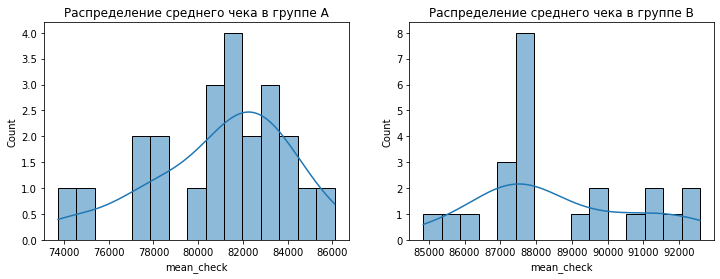

In [17]:
# Фильтруем данные с ежедневными показателями по группам
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

# Создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Строим гистограмму  среднего чека ежедневных покупок в каждой группе
sns.histplot(data=daily_data_a, x='mean_check', bins=15, kde=True, ax=axes[0])
sns.histplot(data=daily_data_b, x='mean_check', bins=15, kde=True, ax=axes[1])

# Задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А')
axes[1].set_title('Распределение среднего чека в группе B');


# Нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости

# Вычисляем результат теста Шапиро-Уилка для выборок
_, p_a = shapiro(daily_data_a['mean_check'])
_, p_b = shapiro(daily_data_b['mean_check'])

# Выводим p-value обеих групп
print('p-value группы А', round(p_a, 2))
print('p-value группы B', round(p_b, 2))

# Cравниваем полученное p-value с уровнем значимости
if p_a < alpha or p_b < alpha:
    print("Отвергаем нулевую гипотезу.", H0)
    print("Альтернативная гипотеза. H1:", H1)
else:
    print("Принимаем нулевую гипотезу.", H0)

Графики показывают, что распределения похожи на <u>нормальные</u>. Так же тест на нормальность *Шапиро-Уилка* показывает положительный результат.

Настало время сравнить варианты дизайна страницы по метрике **среднего чека**. 

Подберём тест для проверки гипотезы о равенстве средних чеков по дням в группах. Для этого проверим размер выборок. Если менее 30, применим **Т-тест**.

Проведём тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислим p-value вашего теста для ежедневного среднего чека в группах А и B. Сравним полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [19]:
# Проверяем размер выборки на количество менее 30
print('Размер выборок в обеих группах менее 30: ', daily_data_a.shape[0] < 30 and daily_data_b.shape[0] < 30)

#  Нулевая и альтернативная гепотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05

# Вычисляем p-value с помощью Т-теста
_, p = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)
print('p-value:', round(p, 2))

if p < alpha:
    print('Отвергаем нулевую гипотезу:', H0)
    print('Принимаем альтернативную гипотезу:', H1)
else:
    print('Принимаем нулевую гипотезу:', H0)

True
p-value: 0.0
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны
Принимаем альтернативную гипотезу: Ежедневный средний чек в группе А меньше, чем в группе B


 **Выводы** по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

 Данные являются *параметрическими*: распределены <u>нормально</u>, тип данных <u>непрерывный</u>. Для сравнения средних чеков ежедневных покупок нам подойдет **Т-тест**, так как размеры выборок <u>менее 30</u>. По результатам теста можем сделать вывод о **статистической значимости** в разнице между ежедневными средними чеками групп. В *группе А* данная метрика <u>меньше</u>, чем в *группе В*.
 ___

Далее построим 95%-ый **доверительный интервал** для среднего чека в каждой группе. Так как выборка ежедневных средних чеков небольшая, используем  $t_{крит}$ в своих расчетах.

Укажем нижнюю и верхнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведём в процентах и округлим до целого.

In [20]:
# Создадим функцию нахождения доверительного интервала для среднего значения выборки
def mean_conf_interval(n, x_mean, x_std, norm=True, gamma=0.95):
    """
    Функция нахождения доверительного интервала для среднего значения.
    z и t критические можно выбирать, исходя из количества выборки.
    Рассчитываются для двусторонней альтернативной гипотезы.

    Args:
        n (int): размер выборки
        x_p (float): стандартное отклонение. Может использоваться как истинное так и выборочное.
        gamma (float, optional): уровень надёжности. Defaults to 0.95.
        norm(bool): выбор критического параметра. True - z-crit, False - t-crit. Defaults to True.

    Returns:
        tuple: lower_bound - нижняя граница, upper_bound - верхняя граница
    """
    alpha = 1 - gamma # уровень значимости
    # Будет ли использоваться z или t критическое
    if norm:
        crit = -norm.ppf(alpha/2) # z критическое
    else:
        k = n - 1
        crit = -t.ppf(alpha/2, k) # t критическое
        
    eps = crit * x_std / (n**0.5) # погрешность
    lower_bound = x_mean - eps # нижняя граница
    upper_bound = x_mean + eps # верхняя граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound), round(upper_bound)


# Параметры для группы А
n = daily_data_a['mean_check'].count()
x_std = daily_data_a['mean_check'].std()
x_mean = daily_data_a['mean_check'].mean()
# Применяем функцию
conf_interval_a = mean_conf_interval(n, x_mean, x_std, norm=False)
print('Доверительный интервал группы А:', conf_interval_a)

# Параметры для группы В
n = daily_data_b['mean_check'].count()
x_std = daily_data_b['mean_check'].std()
x_mean = daily_data_b['mean_check'].mean()
# Применяем функцию
conf_interval_b = mean_conf_interval(n, x_mean, x_std, norm=False)
print('Доверительный интервал группы B:', conf_interval_b)

Доверительный интервал группы А: (79630, 82308)
Доверительный интервал группы B: (87626, 89526)


Проинтерпретируем построенные доверительные интервалы для ежедневных средних чеков в группах. Посмотрим есть ли между ними пересечения?

С уверенностью в `95%` можно утверждать, что **математическое ожидание** в *группе А* находится в интервале от `79630` до `82308` тыс. руб., а в *группе В* от `87626` до `89526` тыс. руб. Верхняя граница доверительного интервала *группы А* <u>ниже</u>, чем нижняя граница интервала *группы В*. Это означает, что пересечений между интервалами групп <u>нет</u>.

## <center> 5. Общий вывод по результатам A/B-теста

В итоге нам необходимо ответить на главные вопросы поставленной задачи: какой вариант дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

*По результатам всего **А/В тестирования** и его анализа можно заключить, что вариант дизайна посадочной страницы, используемый в *группе В*, будет более <u>эффективным</u>. Сравнительные тесты показали, что **конверсия** <u>не имеет</u> разницы между тестируемыми группами, а вот **средний чек** в *группе В* <u>выше</u>, чем в *группе А*. На тепловой карте видно, что соимость тура с максимальным спросом в *группе В* (*Таиланд* (100 000р.) - продано `5227` туров) <u>дороже</u>, чем стоимость самого продаваемого тура в *группе А* (*Турция* (60 000р.) - продано `5271` туров).  
В итоге вариант дизайна тестируемой **группы B** будет **рекомендован** к реализации для всех пользователей сайта.*